This notebook was inspired by neural network & machine learning labs led by [GMUM](https://gmum.net/).

See also [CS231n: Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/convolutional-networks/) (what's below mostly follows this) and [Chapter 9](https://www.deeplearningbook.org/contents/convnets.html) (especially 9.2 *Motivation* and 9.3 *Pooling*) of the Deep Learning book.

The deadline for the tasks in this notebook is 2021-12-13 12:00 (two weeks from today). 

In [2]:
from itertools import product

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.utils import make_grid

# Convolutional neural networks

Convolutional neural networks (CNNs) are a specialized kind of neural network for processing data that has spatial structure. Examples include time-series data (1D) and image data (2D). CNNs make an explicit assumption about the inputs, which allows us to encode certain properties into the architecture (this is the so-called [*inductive bias*](https://en.wikipedia.org/wiki/Inductive_bias) of CNNs). These properties make the model more efficient to implement and reduce the amount of parameters needed. They are based on a mathematical operation called *convolution* (see section 9.1 of [Chapter 9](https://www.deeplearningbook.org/contents/convnets.html) for more).

In a regular neural network, the amount of weights needed goes up very quickly. In CIFAR-10, images are only of size $3\times32\times32$, hence a fully-connected neuron in the first hidden layer would have $3\cdot32\cdot32 = 3072$ weights. This might not seem like a lot, but then for an image of size $3\times200\times200$ you need $3\cdot200\cdot200 = 120000$ weights. You also probably want to have many such neurons, hence the amount of parameters adds up very quickly.


A CNN processes images differently: it arranges its neurons in three dimensions (depth, width, height), as visualized in one layer below. Every layer of a CNN transforms the 3D input volume to a 3D output volume of neuron activations. In the example below, the red input layer holds the image, so its width and height would be the dimensions of the image, and the depth would be 3 (`RGB` channels). 

![cnn](figures/cnn.jpeg)
<center>Source: <a href="https://cs231n.github.io/convolutional-networks">CS231n</a>.</center>

The three relevant hyperparameters of a convolutional layer are *depth*, *stride* and *zero-padding*. The depth is the amount of filters we would like to use. The stride is how many pixels at a time we move the filter when computing the output. Sometimes its convenient to add zeroes around the border; the size of this is the zero-padding.

![stride](figures/stride.jpeg)
<center>Source: <a href="https://cs231n.github.io/convolutional-networks">CS231n</a>.</center>

In the example above there is only one spatial dimension (the $x$-axis), one neuron filter size of $F = 3$, the input size is $W = 5$, and there is zero-padding of $P = 1$.The neuron on the left uses stride $S = 1$, giving output of size $(5 - 3 + 2)/1+1 = 5$. The neuron on the right uses stride of $S = 2$, giving output of size $(5 - 3 + 2)/2+1 = 3$. Stride $S = 3$ could not be used since it wouldn't fit neatly across the volume. In terms of the equation, this can be determined since $(5 - 3 + 2)$ = 4 is not divisible by 3.
The neuron weights in this example are $[1,0,-1]$, and its bias is zero. These weights are shared across all yellow neurons (see parameter sharing below).

![cnn](figures/cnn.gif)
<center>Visualization of a convolutional layer with each depth slice stacked in rows. Source: <a href="https://cs231n.github.io/convolutional-networks">CS231n</a>.</center>

For a 2D image:
- Assume the input is of size $D_1\times H_1\times W_1$ (using the *channel-first* convention, i.e. the number of channels, the width, and the height),
- We require four hyperparameters:
    - the number of filters $K$,
    - the size of the filters $F$,
    - the stride $S$,
    - the amount of padding $P$.
- This produces an input of size $D_2\times H_2\times W_2$, where
    - $W_2=(W_1-F+2P)/S+1$,
    - $H_2=(H_1-F+2P)/S+1$ (analogously to the above),
    - $D_2=K$.
- With parameter sharing, this introduces $F\cdot F\cdot D_1$ weights per filter, for a total of $(F\cdot F\cdot D_1)\cdot K$ weights and $K$ biases.
- In the output, the $d$-th depth slice is the result of performing a convolution of the $d$-th filter over the input volume with a stride of $S$, and the offset by the $d$-th bias.

## Pooling

It is common to periodically insert a pooling layer in-between successive convolutional layers in a CNN architecture. This reduces the amount of parameters and makes the learned representation invariant to small translations of the input (see section 9.3 of [Chapter 9](https://www.deeplearningbook.org/contents/convnets.html) for more). The most commonly used version is *max pooling*, which works similarly to convolution, but instead of performing multiplication you just take the max:

![maxpool](figures/maxpool.jpeg)
<center>Source: <a href="https://cs231n.github.io/convolutional-networks">CS231n</a>.</center>

In what follows we'll describe some features of CNNs that make them particularly relevant.

## Sparse interactions

Traditional neural network layers use matrix multiplication by a matrix of paramaters with separate parameters describing the interaction between each input and output unit (each input unit interacts with every output unit). CNNs, however, only have sparse interactions (the filters are smaller than the input). For example, when processing an image we can still detect meaningful features such as edges with filters that only occupy tens or hundreds of pixels. This means that we can store fewer parameters, which reduces the memory requirements and improves statistical efficiency.

![sparse](figures/sparse.png)
<center>Source: <a href="https://www.deeplearningbook.org/contents/convnets.html">Chapter 9</a> of the Deep Learning book.</center>


## Parameter sharing

Parameter sharing refers to using the same parameter for more than one function in a model. In a traditional neural network, each element of a weight matrix is used exactly once when computing the output of a layer. In a CNN, each filter is used at every position of the input. This means that rather than learning a separate set of parameters for each location, we only learn one. For example, when processing images, it is useful to detect edges in the ﬁrst layer of a convolutional network. The same edges appear more or less everywhere in the image, so it is practical to share parameters across the entire image. (This assumption might not be true in general.)


## Equivariant representations

In the case of convolution, the particular form of parameter sharing causes the layer to have a property called *equivariance to translation*. To say that a function is equivariant means that if the input changes, the output changes the same way. Specifically, if $f$ is equivariant to $g$, then $f(g(x))=g(f(x))$. In the case of convolution, shifting an image by a pixel will produce a shift in the output.


## What do CNNs end up learning? 

![cnn](figures/filters.jpeg)
<center>Source: <a href="https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf">ImageNet Classification with Deep Convolutional Neural Networks</a>.</center> 

These are the filters from the AlexNet paper. Each of the 96 filters shown here is of size $3\times11\times11$, and each one is shared by the $55\cdot55$ neurons in one depth slice. Notice that the parameter sharing assumption is relatively reasonable: if detecting a horizontal edge is important at some location in the image, it should intuitively be useful at some other location as well due to the translationally-invariant structure of images.

To go further down the visualization rabbit hole, see the distill.pub article <a href="https://distill.pub/2018/building-blocks/">The Building Blocks of Interpretability</a>. Furthermore, you can play around with a CNN in your browser: [ConvNetJS CIFAR-10 demo](https://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html).

Your task for today will be to implement a convolutional neural network for multiclass classification on the CIFAR-10 dataset.

## CIFAR-10
The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 $32\times32$ colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Files already downloaded and verified
CIFAR-10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


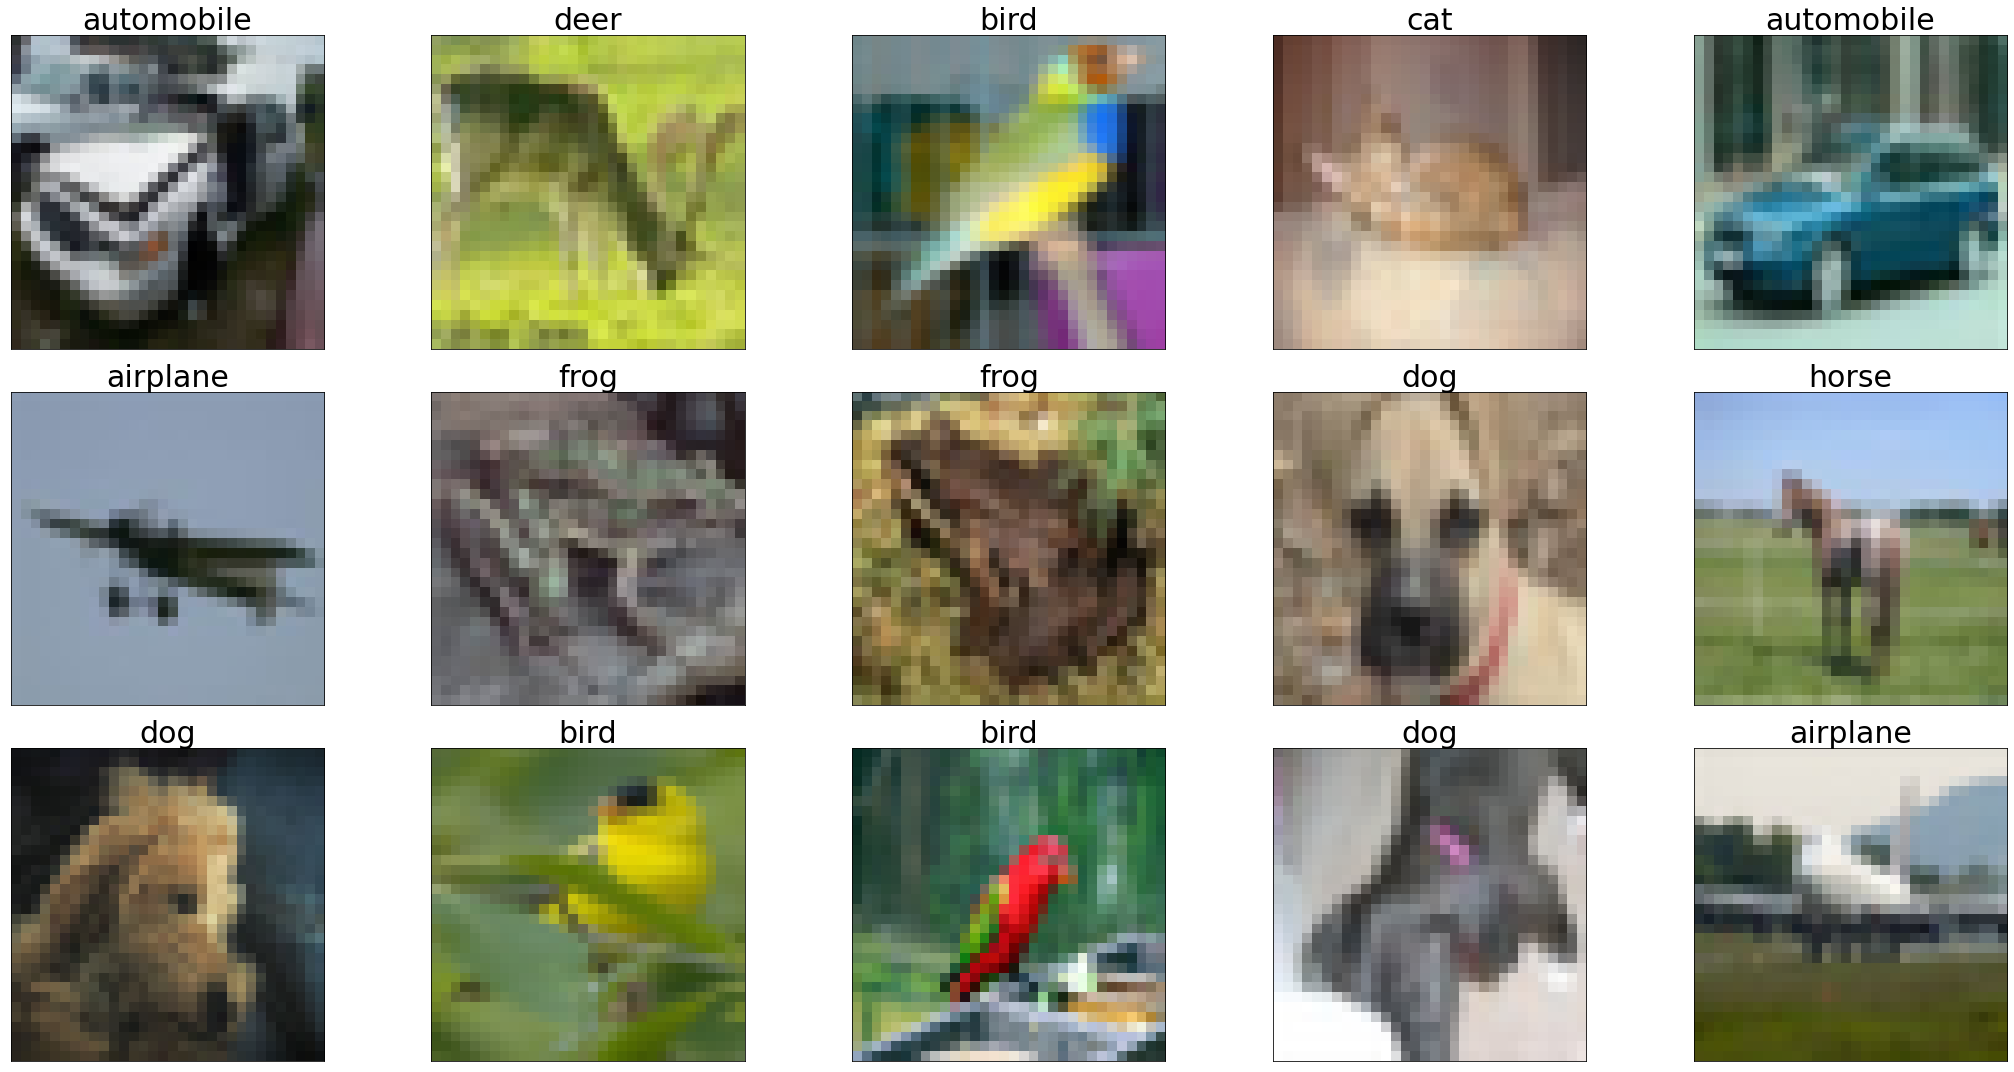

In [21]:
dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
x, y = next(iter(loader))
    
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR-10 classes: {dataset.classes}")

## Task 1 (1.25p)
Implement a convolutional neural network for multiclass classification on CIFAR-10 from scratch. You need to implement both the model and the training loop. Your code should report the loss (during training and testing) and accuracy on the test set (optionally also on the training set). You should achieve 75% accuracy on the test set. You can use any features present in PyTorch.

Some tips:
- Change the runtime to GPU in Google Colab. You need to use `torch.device('cuda')` to train on the GPU (don't forget to send your model and data to the device!).
- Your model should inherit from [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
- In order to have a short feedback loop, when choosing the architecture or hyperparameters don't train for more than a couple epochs.
- Visualize the loss curve to see when it begins to flatten and whether the model is overfitting (by comparing to the loss for the training set).

In [ ]:
# implement your model here
class Model(nn.Module):
    def __init__(self, bn=True):
        super(Model, self).__init__()
        
        self.bn = bn
        if bn:
            self.bn1 = nn.BatchNorm2d(num_features=48)
            self.bn2 = nn.BatchNorm2d(num_features=96)
            self.bn3 = nn.BatchNorm2d(num_features=192)
            self.bn4 = nn.BatchNorm2d(num_features=256)
        else:
            self.bn1 = lambda x: x
            self.bn2 = lambda x: x
            self.bn3 = lambda x: x
            self.bn4 = lambda x: x
            
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=48, kernel_size=(3,3), padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=(3,3), padding=(1,1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=192, kernel_size=(3,3), padding=(1,1))
        self.conv4 = nn.Conv2d(in_channels=192, out_channels=256, kernel_size=(3,3), padding=(1,1))
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(in_features=8*8*256, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=64)
        self.Dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) # 32*32*48
        x = F.relu(self.bn2(self.conv2(x))) # 32*32*96
        x = self.pool(x) # 16*16*96
        x = self.Dropout(x)
        x = F.relu(self.bn3(self.conv3(x))) # 16*16*192
        x = F.relu(self.bn4(self.conv4(x))) # 16*16*256
        x = self.pool(x) # 8*8*256
        x = self.Dropout(x)
        x = x.view(-1, 8*8*256)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.Dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
# load in the data here
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2023, 0.1994, 0.2010)

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=Compose([ToTensor(), Normalize(cifar_mean, cifar_std)]))

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=Compose([ToTensor(), Normalize(cifar_mean, cifar_std)]))

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=2)

In [ ]:
# implement your training loop with all the needed hyperparameters here
# Epoch 20 | Progress: 99% | loss: 0.174	| Accuracy: 79.44
n_epochs = 20
log_interval = 100

device = torch.device('cuda')

net = Model()
net = net.to(device)

lr = 0.001
optimizer = optim.Adam(net.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    running_loss = 0.
    for i, (inputs, labels) in enumerate(train_loader):

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (i + 1) % log_interval == 0:
            progress = int(100 * (i + 1) * train_loader.batch_size / len(train_loader.dataset))
            print(f"\rEpoch {epoch + 1} | Progress: {progress}% | loss: {running_loss / log_interval:.3f}", end="")
            running_loss = 0.0

    with torch.no_grad():        
        correct = 0     
        for _, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = net(inputs)
                correct += (outputs.argmax(1) == labels).sum().item()

    print(f'\t| Accuracy: {100 * correct / len(test_loader.dataset):.2f}')

## Data augmentation
Data augmentation is a technique to synthetically increase the amount of data by adding slightly modified copies of already existing data. The `torchvision` package contains many transformations useful for this task.

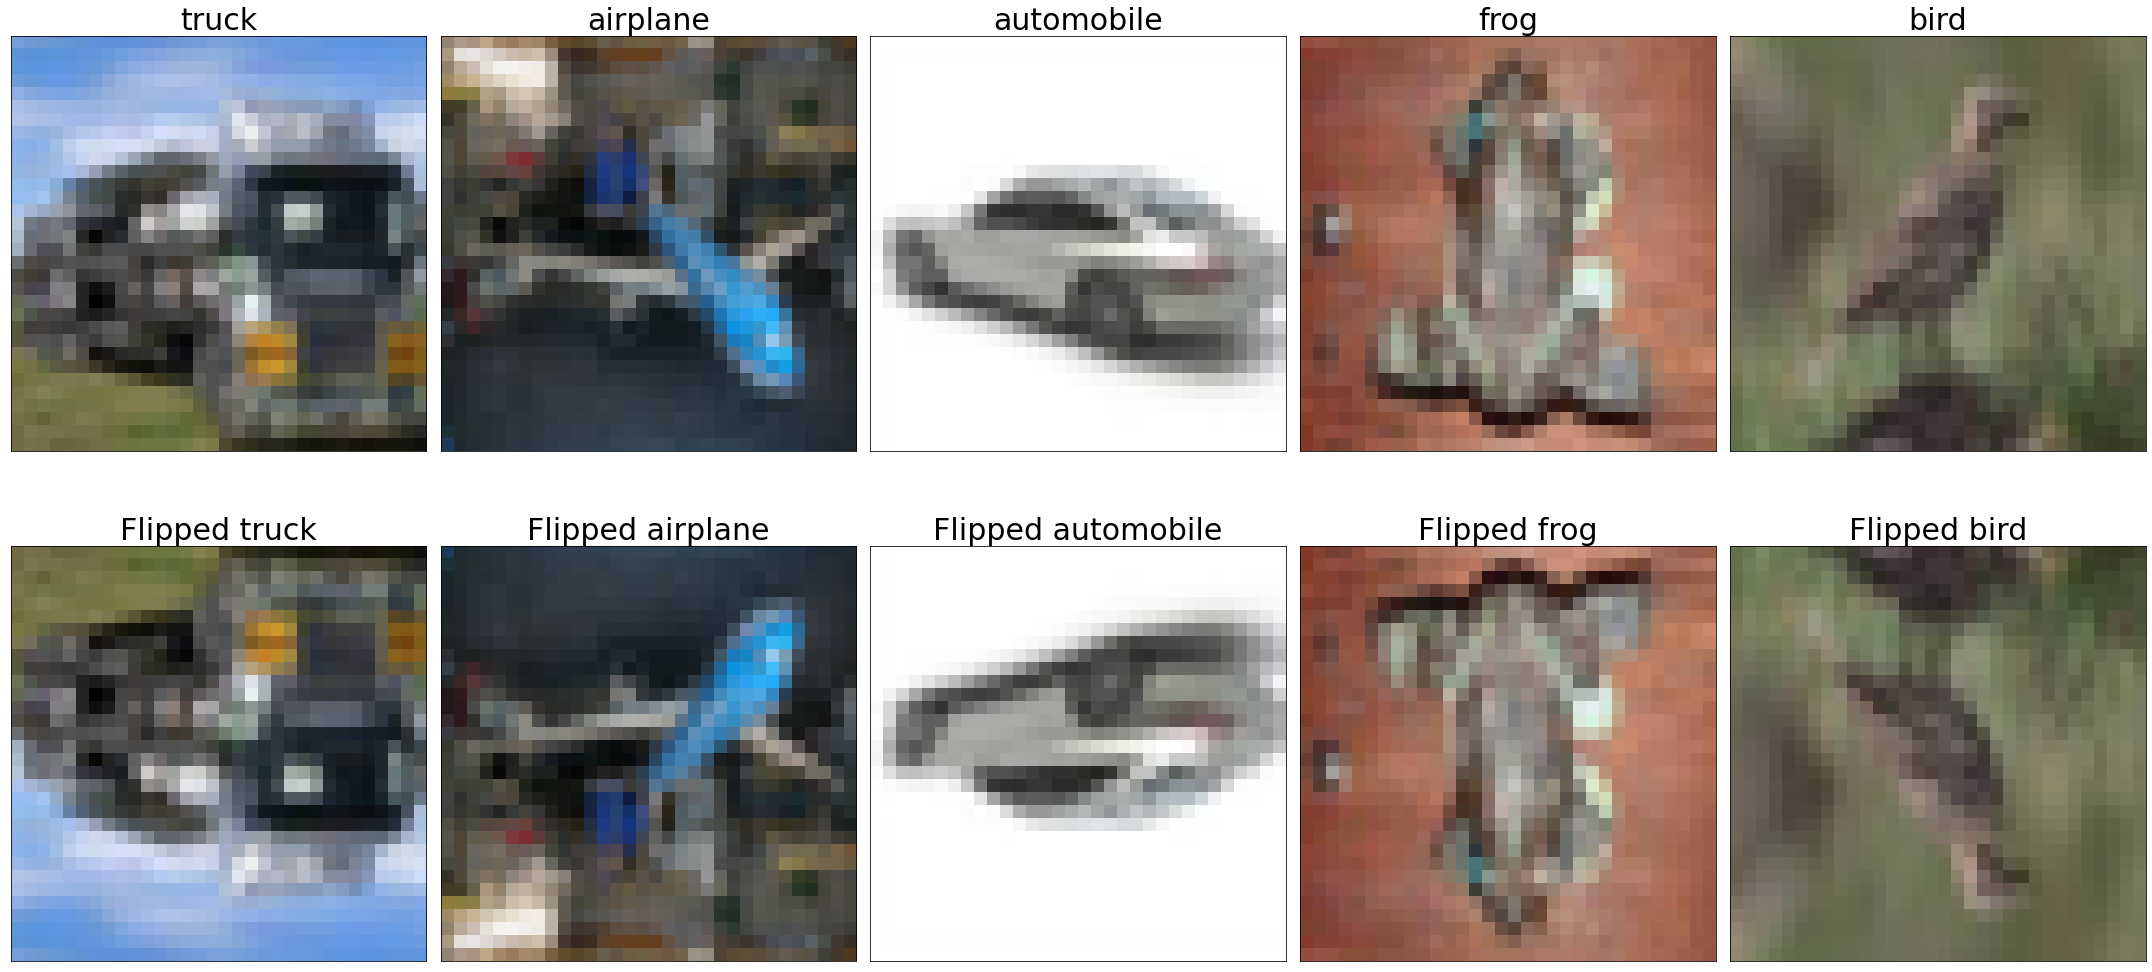

In [18]:
from torchvision.transforms import RandomVerticalFlip

dataset = CIFAR10(root='.', train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

flip = RandomVerticalFlip(p=1) 

# get a single batch
x, y = next(iter(loader))

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])
    
for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()

## Task 2 (0.25p)
Utilizing the functionality from [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html) add augmentations to the training set and see how much that improves the accuracy of your model from the previous task. You can search the internet for typical augumentations for CIFAR-10.

In [ ]:
# load in the data with the augumentations here
from torchvision.transforms import RandomCrop, RandomHorizontalFlip

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=Compose([RandomCrop(32, padding=4), 
                                           RandomHorizontalFlip(p=0.5), 
                                           ToTensor(), 
                                           Normalize(cifar_mean, cifar_std)]))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
# rerun the training loop from the previous task here
# Epoch 20 | Progress: 89% | loss: 0.368	| Accuracy: 84.73
for epoch in range(n_epochs):
    running_loss = 0.
    for i, (inputs, labels) in enumerate(train_loader):

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (i + 1) % log_interval == 0:
            progress = int(100 * (i + 1) * train_loader.batch_size / len(train_loader.dataset))
            print(f"\rEpoch {epoch + 1} | Progress: {progress}% | loss: {running_loss / log_interval:.3f}", end="")
            running_loss = 0.0

    with torch.no_grad():        
        correct = 0     
        for _, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = net(inputs)
                _ , predicted = torch.max(outputs, 1)
                correct += (outputs.argmax(1) == labels).sum().item()

    print(f'\t| Accuracy: {100 * correct / len(test_loader.dataset):.2f}')

## Bonus
For bonus points you can implement the max pooling and convolutional layers.

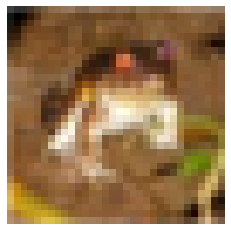

In [19]:
cifar_sample = np.load('resources/cifar_sample.npy')
np_image = cifar_sample[0]
image = torch.tensor(np_image)
plt.axis('off')
_ = plt.imshow(np_image.transpose(1,2,0)) 

An image of a frog from the CIFAR-10 dataset.

## Task 3 (Bonus 1p)
Implement the max pooling layer.

In [7]:
def max_pooling(image: torch.tensor, 
                kernel_size: int, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param kernel_size: int 
        Size of the square pooling kernel
    :param stride: int
        Stride to use in pooling
    :param padding: int
        Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    # calculate the dimensions of the output image
    out_height = int(((img_height - kernel_size + 2 * padding) / stride) + 1)
    out_width = int(((img_width - kernel_size + 2 * padding) / stride) + 1)
    out_channels = img_channels

    if padding > 0:
        padded_height = img_height + 2 * padding
        padded_width = img_width + 2 * padding

        padded_img = torch.zeros((img_channels, padded_height, padded_width))
        padded_img[:, padding:-padding, padding:-padding] = image
    else:
        padded_height = img_height
        padded_width = img_width
        padded_img = image

    out = torch.zeros((out_channels, out_height, out_width))

    for i in range(0, padded_height - kernel_size + 1, stride):

        for j in range(0, padded_width - kernel_size + 1, stride):

            img_crop = padded_img[:, i:i+kernel_size, j:j+kernel_size]

            out[:, i // stride, j // stride] = torch.max(torch.max(img_crop, dim=2)[0], dim=1)[0]

    return out

The cell below will test your implementation.

In [8]:
kernel_sizes = [4, 5, 6]
paddings = [0, 1, 2]
strides = [1, 2, 3, 4]

for kernel_size, stride, padding in product(kernel_sizes, strides, paddings):
    out = max_pooling(image, kernel_size=kernel_size, stride=stride, padding=padding)
    out_torch = torch.nn.functional.max_pool2d(input=image.unsqueeze(0), kernel_size=kernel_size, padding=padding, stride=stride)
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

## Task 4 (Bonus 1.5p)
Implement convolution for a 2D image.

Hint: use the `im2col` approach (cf. [CS231n](https://cs231n.github.io/convolutional-networks/)) or just code everything as a nested loop (the implementation doesn't have to be computationally optimal).

In [9]:
def convolution(image: torch.tensor, 
                filters: torch.tensor, 
                bias: torch.tensor, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param filters: torch.Tensor 
        Filters to use in convolution of shape (K, C, F, F)
    :param bias: torch.Tensor 
        Bias vector of shape (K,)
    :param stride: int
        Stride to use in convolution
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape 
    n_filters, filter_channels, filter_size, filter_size = filters.shape 
    # calculate the dimensions of the output image
    out_height = int(((img_height - filter_size + 2 * padding) / stride) + 1)
    out_width = int(((img_width - filter_size + 2 * padding) / stride) + 1)
    out_channels = n_filters
    
    if padding > 0:
        padded_height = img_height + 2 * padding
        padded_width = img_width + 2 * padding

        padded_img = torch.zeros((img_channels, padded_height, padded_width))
        padded_img[:, padding:-padding, padding:-padding] = image
    else:
        padded_height = img_height
        padded_width = img_width
        padded_img = image

    out = torch.zeros((out_channels, out_height, out_width))

    for out_c in range(out_channels):

        for i in range(0, padded_height - filter_size + 1, stride):

            for j in range(0, padded_width - filter_size + 1, stride):

                weights = filters[out_c]
                img_crop = padded_img[:, i:i+filter_size, j:j+filter_size]
                
                res = torch.sum(weights * img_crop) + bias[out_c]

                out[out_c, i // stride, j // stride] = res
                
    return out

The cell below will test your implementation.

In [10]:
paddings = [0, 1, 2, 3]
strides = [1, 2, 3, 4]
filters = [(torch.randn((2,3,3,3)), torch.ones((2))),
           (torch.randn((2,3,5,5)), torch.ones((2))),
           (torch.randn((5,3,1,1)), torch.ones((5)))]

for (filt, bias), stride, padding in product(filters, strides, paddings):
    out = convolution(image, filt, bias, stride=stride, padding=padding)
    out_torch = torch.conv2d(input=image.unsqueeze(0), weight=filt, bias=bias, padding=padding, stride=stride)
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)